# Perturb and Measure Metrics with Referee

In [5]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pandas as pd
from sklearn import metrics

import matplotlib.pyplot as plt

from sktime.classifiers.shapelet_based import MrSEQLClassifier
from sklearn.linear_model import RidgeClassifierCV
from scipy.interpolate import interp1d

from utils.noise import Noise
import utils.prep as prep
import utils.visualize as vis
import utils.noise as noise
from utils.explanation import all_accuracy

from utils.rocket_functions import generate_kernels, apply_kernels

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%reload_ext autoreload

In [9]:
ds_list = ['CBF', 'CMJ', 'Coffee', 'ECG200', 'GunPoint']
ds_dir = 'data'


#### Functions to save accuracy record by Mr-SEQL and ROCKET as referee

In [10]:
def all_accuracy_rocket(train_x, train_y, trained_model, classifier = 'MrSEQL-SM', noise_type = 1,  ds = 'CMJ'):
    '''
    Calculate accuracy for all noisy data range with test data
    '''
    ms = trained_model   
    accuracy = []
    
    col_names = ['dataset','weights', 'type', 'noise_level', 'acc']
    df = pd.DataFrame(columns = col_names)

    for noise_level in range(0,101,10):
        # load test data
        if gaussian_noise: test_file  = 'output/noisy_ds/gaussian/%s_%s%d_type%d_TEST.txt' %(ds, classifier, noise_level, noise_type)
        else: test_file  = 'output/noisy_ds/centroid/%s_%s%d_type%d_TEST.txt' %(ds, classifier, noise_level, noise_type)
        
        test_data = np.genfromtxt(test_file, delimiter=',')
        test_x, test_y = test_data[:,1:], test_data[:,0]
        X_test_transform = apply_kernels(X = test_x, kernels = kernels)
    
        predicted = ms.predict(X_test_transform)
        
        acc = metrics.accuracy_score(test_y, predicted)
        df = df.append({'dataset': ds,
                        'weights':c,
                        'type': noise_type,
                        'noise_level': noise_level,  'acc': acc }, 
                   ignore_index=True)
        accuracy.append(acc)
    return df, np.array(accuracy)


def all_accuracy_mrseql(train_x, train_y, trained_model, classifier = 'MrSEQL-SM', noise_type = 1,  ds = 'CMJ'):
    '''
    Calculate accuracy for all noisy data range with test data
    '''
    ms = trained_model   
    accuracy = []
    
    col_names = ['dataset','weights', 'type', 'noise_level', 'acc']
    df = pd.DataFrame(columns = col_names)

    for noise_level in range(0,101,10):
        # load test data
        if gaussian_noise: test_file  = 'output/noisy_ds/gaussian/%s_%s%d_type%d_TEST.txt' %(ds, classifier, noise_level, noise_type)
        else: test_file  = 'output/noisy_ds/centroid/%s_%s%d_type%d_TEST.txt' %(ds, classifier, noise_level, noise_type)
        
        test_data = np.genfromtxt(test_file, delimiter=',')
        test_x, test_y = test_data[:,1:], test_data[:,0]
        predicted = ms.predict(test_x)
        
        acc = metrics.accuracy_score(test_y, predicted)
        df = df.append({'dataset': ds,
                        'weights':c,
                        'type': noise_type,
                        'noise_level': noise_level,  'acc': acc }, 
                   ignore_index=True)
        accuracy.append(acc)
    return df, np.array(accuracy)

def save_weight(model, test_data, labels, predicted, ds):
        from sklearn import preprocessing
        le = preprocessing.LabelEncoder()
        le.fit(predicted)
        new_predicted = le.transform(predicted)
        weights = np.empty(dtype=float, shape=(0,test_data.shape[1]))
        
        print('   Original    predicted class: ', np.unique(predicted))
        print('   Transformed predicted class: ', np.unique(new_predicted))
        
        
        for i, ts in enumerate(test_data):
            w = model.map_sax_model(ts)
            pred_class = int(new_predicted[i])
            w = [w[pred_class]]
            
            weights = np.append(weights, w, axis = 0)
        fileName = 'output/explanation_weight/weights_MrSEQL_%s.txt' % ds
        np.savetxt(fileName, weights, delimiter=",")


## 1. Perturb the test dataset

Dataset: CBF
.   Perturbing test data with weights from MrSEQL-SM
.   Done perturbation for test data with weights from MrSEQL-SM
.   Perturbing test data with weights from ResNetCAM
.   Done perturbation for test data with weights from ResNetCAM
DONE
Dataset: CMJ
.   Perturbing test data with weights from MrSEQL-SM
.   Done perturbation for test data with weights from MrSEQL-SM
.   Perturbing test data with weights from ResNetCAM
.   Done perturbation for test data with weights from ResNetCAM
.   Perturbing test data with weights from MrSEQL-LIME
.   Done perturbation for test data with weights from MrSEQL-LIME
DONE
Dataset: Coffee
.   Perturbing test data with weights from MrSEQL-SM
.   Done perturbation for test data with weights from MrSEQL-SM
.   Perturbing test data with weights from ResNetCAM
.   Done perturbation for test data with weights from ResNetCAM
DONE
Dataset: ECG200
.   Perturbing test data with weights from MrSEQL-SM
.   Done perturbation for test data with weights fr

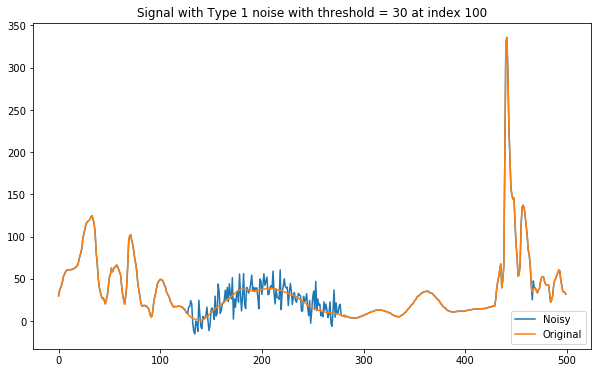

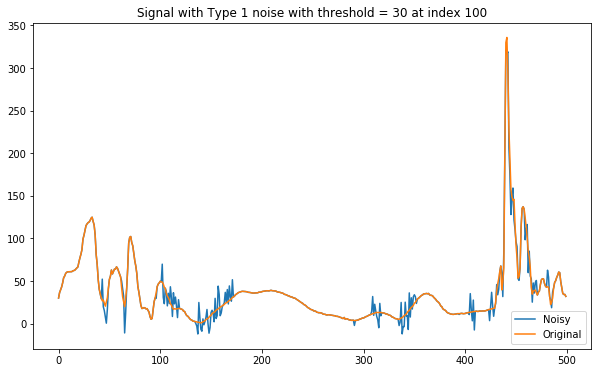

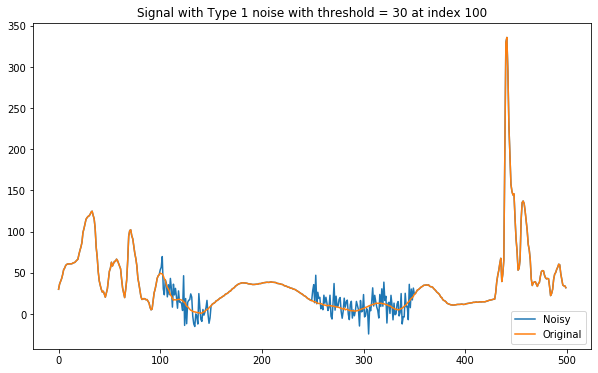

In [19]:
import utils.prep as prep

ds_list = ['CBF', 'CMJ', 'Coffee', 'ECG200', 'GunPoint']
explanation_others = ['MrSEQL-SM', 'ResNetCAM']
explanation_CMJ = ['MrSEQL-SM', 'ResNetCAM', 'MrSEQL-LIME']
gaussian_noise = True


for ds in ds_list:
    print('Dataset: %s' %ds)
    explanation_list = explanation_CMJ if ds in ['CMJ','GunPoint'] else explanation_others
    
    test_file  = os.path.join(ds_dir, ds, ds+'_TEST')
    test_data = np.genfromtxt(test_file, delimiter=',')
    test_x = test_data[:,1:]
    test_y = test_data[:,0]
    
    train_file  = os.path.join(ds_dir, ds, ds+'_TRAIN')
    train_data = np.genfromtxt(train_file, delimiter=',')
    train_x = train_data[:,1:]
    train_y = train_data[:,0]
    
    
        
    for c in explanation_list:
        print('.   Perturbing test data with weights from %s' %c)
        if c == 'MrSEQL-SM':       test_weight_file = 'output/explanation_weight/weights_MrSEQL_%s.txt' % ds
        elif c == 'MrSEQL-LIME':    test_weight_file = 'output/explanation_weight/weights_LIME_%s.txt' % ds
        elif c == 'ResNetCAM':      test_weight_file = 'output/resnet_weights/ResNet_%s_BestModel.hdf5_model_weights.txt' % ds
        else: 
            print('ERROR')
            break
        test_weight = np.genfromtxt(test_weight_file, delimiter = ',')
        if c =='MrSEQL-LIME': test_weight = np.repeat(test_weight, test_x.shape[1]//10).reshape(len(test_y),-1)
        noise = Noise(test_x,test_y,train_x,test_weight, dataset_name= ds)
        noise.norm_weight()
        for noise_type in [1,2]:
            for t in range(0,101,10):
                if gaussian_noise == True:
                    n = noise.add_noise_gaussian(noise_type = noise_type, threshold = t)
                    txt = 'noisy_ds/gaussian/%s_%s%d_type%d' %(ds, c, t, noise_type) 
                else:
                    n = noise.add_noise_centroid(noise_type = noise_type, threshold = t)
                    txt = 'noisy_ds/centroid/%s_%s%d_type%d' %(ds, c, t, noise_type)
                
                if ds == 'CMJ' and t == 30 and noise_type == 1:
                    noise.visualize(100)
#                 prep.write_to_std(n, test_y, dataset= txt, train = False)
    
        print('.   Done perturbation for test data with weights from %s' %c)
    print('DONE')

## 2. Get new accuracy scores and the explanation AUC

### 2.1 Use Mr-SEQL as the referee classifier

In [21]:
ds_list = ['CBF', 'CMJ', 'Coffee', 'ECG200', 'GunPoint']
ds_dir = 'data'

col_names1 = ['dataset', 'weights', 'type', 'explanation_auc']
auc_df_1 = pd.DataFrame(columns = col_names1)

col_names3 = ['dataset', 'weights','type', 'noise_level', 'acc']
acc_df_1 = pd.DataFrame(columns = col_names3)

weights_from_classifier_others = ['MrSEQL-SM', 'ResNetCAM']
weights_from_classifier_LIME = ['MrSEQL-SM', 'ResNetCAM', 'MrSEQL-LIME']
gaussian_noise = True


for ds in ds_list:
    print('Dataset: %s' %ds)
    train_file =  os.path.join(ds_dir, ds, ds+'_TRAIN')
    train_data = np.genfromtxt(train_file,delimiter=',')
    train_x, train_y = train_data[:,1:], train_data[:,0]
    
    ##fit a classifier: MrSEQL
    ms = MrSEQLClassifier(seql_mode='fs')
    ms.fit(train_x, train_y)
    
    weight_list = weights_from_classifier_LIME if ds in ['CMJ', 'GunPoint'] else weights_from_classifier_others
    
    for c in weight_list:
        print('.   Perturbed with weights from %s' %c)
        for noise_type in [1,2]:
            local_df, acc = all_accuracy_mrseql(train_x, train_y,  ms, noise_type = noise_type,  
                                                classifier = c, ds = ds)

            acc_df_1 = pd.concat([acc_df_1,local_df],ignore_index=True)
            steps = np.arange(0,1.1, 0.1)
            exp_auc = metrics.auc(steps, acc)
            print('.        Type %d Explanation AUC: %.4f' %(noise_type, exp_auc))
            auc_df_1 = auc_df_1.append({'dataset': ds, 
                                    'weights': c, 
                                    'type': noise_type,
                                    'explanation_auc': exp_auc }, ignore_index=True)
            

Dataset: CBF
.   Perturbed with weights from MrSEQL-SM
.        Type 1 Explanation AUC: 0.9991
.        Type 2 Explanation AUC: 0.9992
.   Perturbed with weights from ResNetCAM
.        Type 1 Explanation AUC: 0.9993
.        Type 2 Explanation AUC: 0.9988
Dataset: CMJ
.   Perturbed with weights from MrSEQL-SM
.        Type 1 Explanation AUC: 0.9441
.        Type 2 Explanation AUC: 0.9486
.   Perturbed with weights from ResNetCAM
.        Type 1 Explanation AUC: 0.9453
.        Type 2 Explanation AUC: 0.9447
.   Perturbed with weights from MrSEQL-LIME
.        Type 1 Explanation AUC: 0.9441
.        Type 2 Explanation AUC: 0.9525
Dataset: Coffee
.   Perturbed with weights from MrSEQL-SM
.        Type 1 Explanation AUC: 0.9625
.        Type 2 Explanation AUC: 0.9911
.   Perturbed with weights from ResNetCAM
.        Type 1 Explanation AUC: 0.9696
.        Type 2 Explanation AUC: 0.9875
Dataset: ECG200
.   Perturbed with weights from MrSEQL-SM
.        Type 1 Explanation AUC: 0.8110
.   

In [22]:
df1, df2 = auc_df_1.round(4), acc_df_1.round(4)
if gaussian_noise:
    df1.to_csv('csvout/gaussian/auc_df_mrseql.csv', index=False)
    df2.to_csv('csvout/gaussian/acc_df_mrseql.csv', index=False)
else:
    df1.to_csv('csvout/centroid/auc_df_mrseql.csv', index=False)
    df2.to_csv('csvout/centroid/acc_df_mrseql.csv', index=False)

### 2.2 Use ROCKET as the referee classifier

In [23]:
ds_list = ['CBF', 'CMJ', 'Coffee', 'ECG200', 'GunPoint']
ds_dir = 'data'


col_names1 = ['dataset', 'weights', 'type', 'explanation_auc']
auc_df = pd.DataFrame(columns = col_names1)

col_names3 = ['dataset', 'weights','type', 'noise_level', 'acc']
acc_df = pd.DataFrame(columns = col_names3)


weights_from_classifier_others = ['MrSEQL-SM', 'ResNetCAM']
weights_from_classifier_LIME = ['MrSEQL-SM', 'ResNetCAM', 'MrSEQL-LIME']

for ds in ds_list:
    print('Dataset: %s' %ds)
    
    train_file =  os.path.join(ds_dir, ds, ds+'_TRAIN')
    train_data = np.genfromtxt(train_file,delimiter=',')
    train_x, train_y = train_data[:,1:], train_data[:,0]
    
    # fit a classifier
    # (1) generate random kernels
    kernels = generate_kernels(input_length = train_x.shape[1], num_kernels = 10_000)

    # (2) transform the training data and train a classifier
    X_training_transform = apply_kernels(X = train_x, kernels = kernels)    
    
    ms = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10), normalize = True)
    ms.fit(X_training_transform, train_y)
    weight_list = weights_from_classifier_LIME if ds in ['CMJ','GunPoint'] else weights_from_classifier_others
#     weight_list = ['MrSEQL-LIME']
    
    for c in weight_list:
        print('.   Perturbed with weights from %s' %c)
        for noise_type in [1,2]:
            local_df, acc = all_accuracy_rocket(train_x, train_y,  ms, noise_type = noise_type,  
                                                classifier = c, ds = ds)

            acc_df = pd.concat([acc_df,local_df],ignore_index=True)
            steps = np.arange(0,1.1, 0.1)
            exp_auc = metrics.auc(steps, acc)
            print('.        Type %d Explanation AUC: %.4f' %(noise_type, exp_auc))
            auc_df = auc_df.append({'dataset': ds, 
                                    'weights': c, 
                                    'type': noise_type,
                                    'explanation_auc': exp_auc }, ignore_index=True)

Dataset: CBF
.   Perturbed with weights from MrSEQL-SM
.        Type 1 Explanation AUC: 0.9938
.        Type 2 Explanation AUC: 0.9958
.   Perturbed with weights from ResNetCAM
.        Type 1 Explanation AUC: 0.9944
.        Type 2 Explanation AUC: 0.9956
Dataset: CMJ
.   Perturbed with weights from MrSEQL-SM
.        Type 1 Explanation AUC: 0.8701
.        Type 2 Explanation AUC: 0.9321
.   Perturbed with weights from ResNetCAM
.        Type 1 Explanation AUC: 0.8941
.        Type 2 Explanation AUC: 0.8930
.   Perturbed with weights from MrSEQL-LIME
.        Type 1 Explanation AUC: 0.8919
.        Type 2 Explanation AUC: 0.9260
Dataset: Coffee
.   Perturbed with weights from MrSEQL-SM
.        Type 1 Explanation AUC: 1.0000
.        Type 2 Explanation AUC: 1.0000
.   Perturbed with weights from ResNetCAM
.        Type 1 Explanation AUC: 1.0000
.        Type 2 Explanation AUC: 1.0000
Dataset: ECG200
.   Perturbed with weights from MrSEQL-SM
.        Type 1 Explanation AUC: 0.9005
.   

In [24]:
df1, df2 = auc_df.round(4), acc_df.round(4)
if gaussian_noise:
    df1.to_csv('csvout/gaussian/auc_df_rocket.csv', index = False)
    df2.to_csv('csvout/gaussian/acc_df_rocket.csv', index=False)
else:
    df1.to_csv('csvout/centroid/auc_df_rocket.csv', index = False)
    df2.to_csv('csvout/centroid/acc_df_rocket.csv', index=False)